In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('complaints.csv',nrows=100000)
complaints = data['Consumer complaint narrative']

In [3]:
def preprocess_text(text):
    if isinstance(text, str):  
        return text.lower().split()
    return []

In [4]:
vocabulary = set()
for complaint in complaints:
    vocabulary.update(preprocess_text(complaint))
vocabulary = list(vocabulary)
word_to_index = {word: i for i, word in enumerate(vocabulary)}

In [17]:
def text_to_vector(text):
    vector = np.zeros(len(vocabulary))
    for word in preprocess_text(text):
        if word in word_to_index:
            vector[word_to_index[word]] = 1
    return vector

In [18]:
X = np.array([text_to_vector(complaint) for complaint in complaints if isinstance(complaint, str)])  # exclude missing values

In [19]:
def k_means(data, k, max_iterations=100):
    num_samples, num_features = data.shape
    centroids = data[random.sample(range(num_samples), k)]
    
    for _ in range(max_iterations):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        assignments = np.argmin(distances, axis=1)
        
        new_centroids = np.array([data[assignments == i].mean(axis=0) for i in range(k)])
        
        if np.all(np.abs(centroids - new_centroids) < 1e-4):
            break
        
        centroids = new_centroids
    
    return assignments, centroids

In [20]:
def stability_analysis(data, num_clusters_range, num_runs):
    stability_scores = np.zeros((len(num_clusters_range), len(num_clusters_range)))
    
    for i, k1 in enumerate(num_clusters_range):
        for j, k2 in enumerate(num_clusters_range):
            for _ in range(num_runs):
                assignments1, _ = k_means(data, k1)
                assignments2, _ = k_means(data, k2)
                stability_scores[i, j] += np.mean(assignments1 == assignments2)
    
    avg_stability = np.mean(stability_scores, axis=1)
    return avg_stability

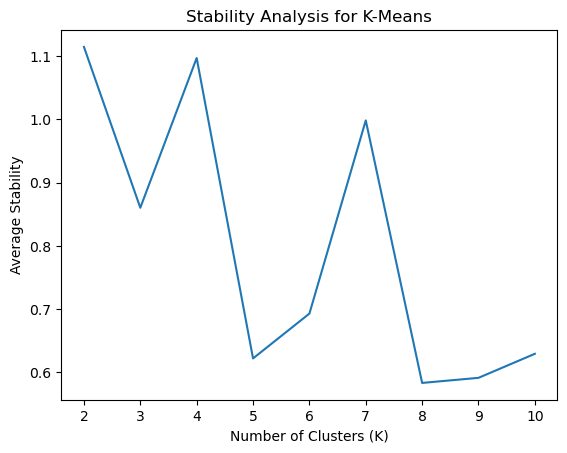

In [21]:
num_clusters_range = range(2, 11)
num_runs = 5
avg_stability = stability_analysis(X, num_clusters_range, num_runs)


plt.plot(num_clusters_range, avg_stability)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Average Stability')
plt.title('Stability Analysis for K-Means')
plt.show()

In [22]:
assignments, _ = k_means(X, 5)

In [23]:
cluster_labels = []
for cluster_id in range(5):  # Assuming K=5 clusters
    cluster_indices = np.where(assignments == cluster_id)[0]
    cluster_products = data.loc[cluster_indices, 'Product'].value_counts()
    cluster_issues = data.loc[cluster_indices, 'Issue'].value_counts()
    
    most_common_product = cluster_products.idxmax()
    most_common_issue = cluster_issues.idxmax()
    
    cluster_labels.append((most_common_product, most_common_issue))

# Print the cluster interpretations
for cluster_id, (product, issue) in enumerate(cluster_labels):
    print(f"Cluster {cluster_id+1}: Most Common Product - {product}, Most Common Issue - {issue}")

Cluster 1: Most Common Product - Credit reporting, credit repair services, or other personal consumer reports, Most Common Issue - Improper use of your report
Cluster 2: Most Common Product - Credit reporting, credit repair services, or other personal consumer reports, Most Common Issue - Incorrect information on your report
Cluster 3: Most Common Product - Credit reporting, credit repair services, or other personal consumer reports, Most Common Issue - Problem with a credit reporting company's investigation into an existing problem
Cluster 4: Most Common Product - Credit reporting, credit repair services, or other personal consumer reports, Most Common Issue - Problem with a credit reporting company's investigation into an existing problem
Cluster 5: Most Common Product - Mortgage, Most Common Issue - Struggling to pay mortgage


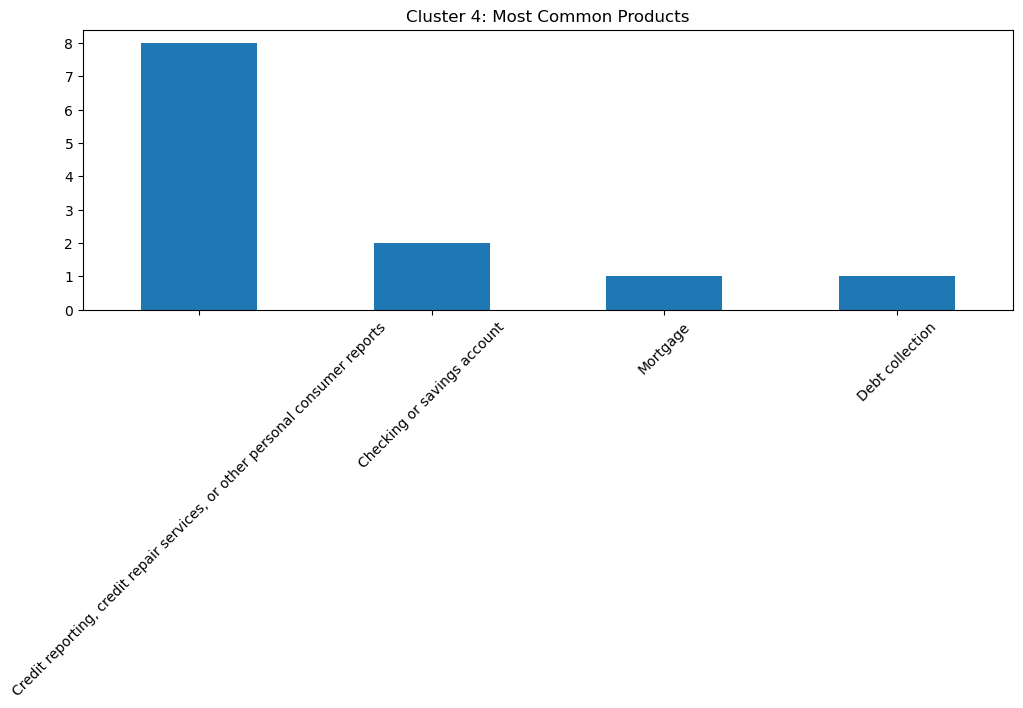

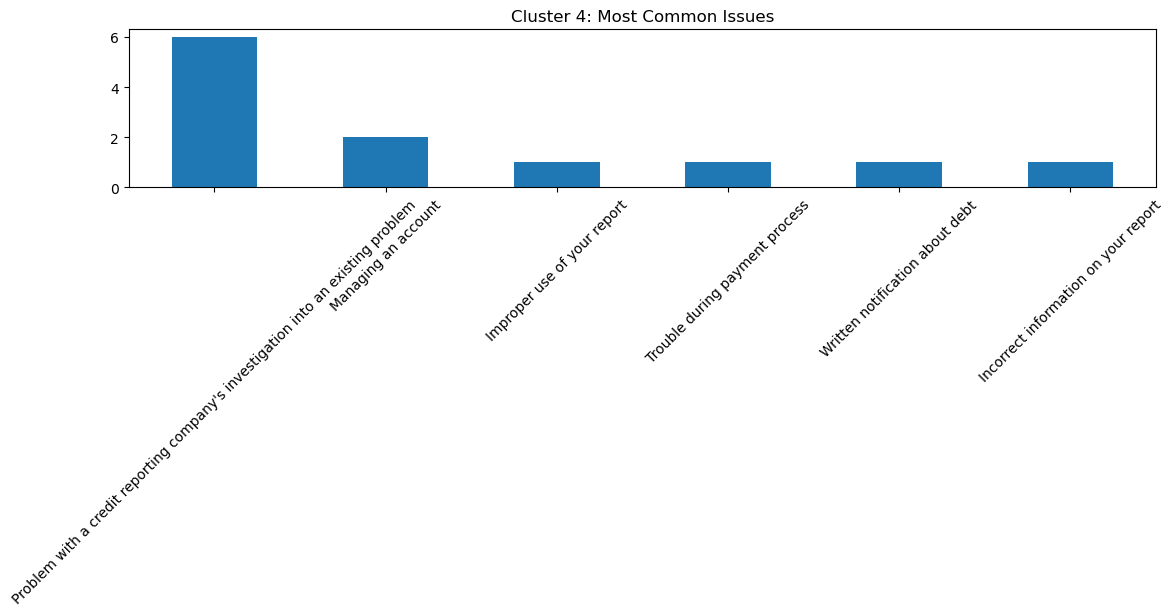

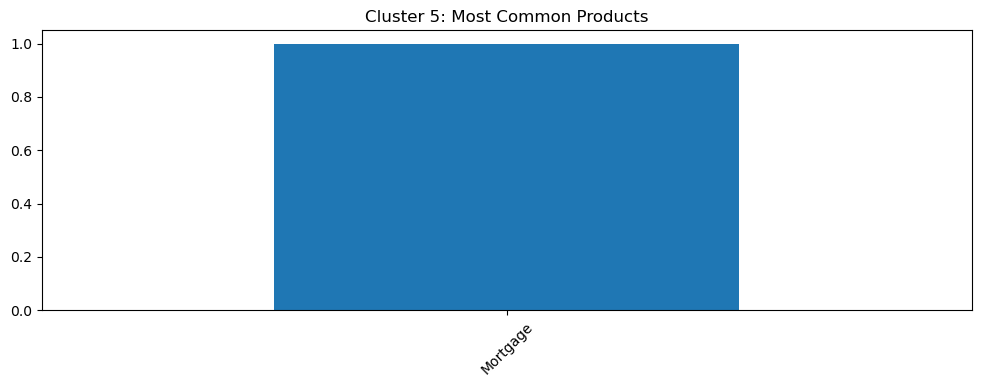

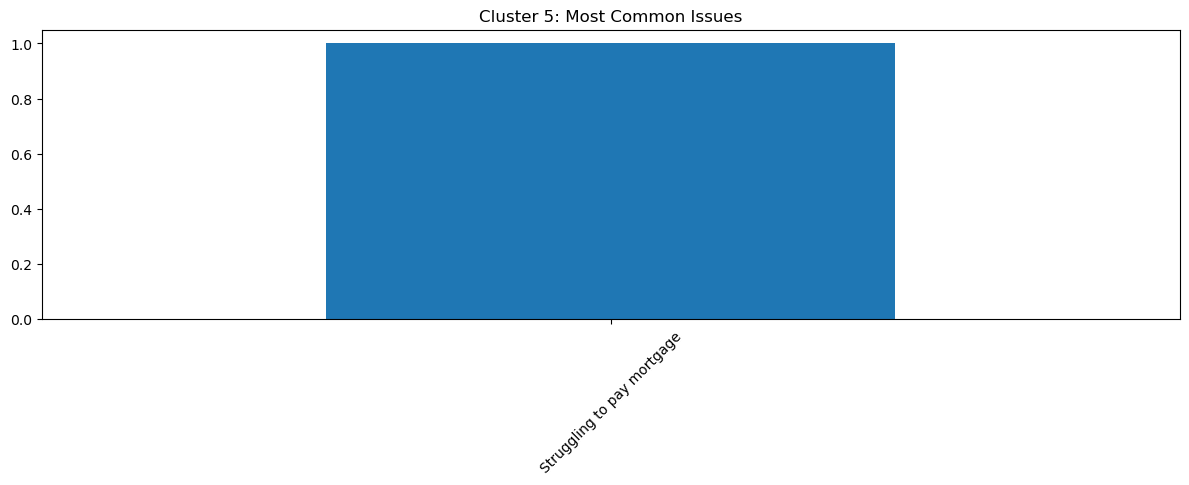

In [24]:
for cluster_id, (product, issue) in enumerate(cluster_labels):
    if cluster_id in [3, 4]:  # Assuming cluster IDs are 0-indexed
        plt.figure(figsize=(12, 8))
        
        # Filter cluster data based on cluster_id
        cluster_indices = np.where(assignments == cluster_id)[0]
        cluster_data = data.loc[cluster_indices]
        
        # Create a subset for visualization
        top_n_categories = 10  # Set the desired number of top categories
        top_categories = cluster_data['Product'].value_counts().nlargest(top_n_categories).index
        cluster_data_subset = cluster_data[cluster_data['Product'].isin(top_categories)]
        
        # Plot most common products
        plt.subplot(2, 1, 1)
        cluster_data_subset['Product'].value_counts().plot(kind='bar')
        plt.title(f'Cluster {cluster_id+1}: Most Common Products')
        plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
        
        # Create a new figure for most common issues
        plt.figure(figsize=(12, 8))
        
        # Plot most common issues
        plt.subplot(2, 1, 1)
        cluster_data['Issue'].value_counts().plot(kind='bar')
        plt.title(f'Cluster {cluster_id+1}: Most Common Issues')
        plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
        
        # Adjust layout for better spacing
        plt.tight_layout()
        plt.show()